#EXERCISE 1
######Forest Covertype Dataset - UCI ML Repository
######Multilayer NN, Deep-Cross, Wide-Deep

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Loading the dataset into pandas dataframe
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()


Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)] #40 soil types
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)] #4 wilderness_areas

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

data = pd.concat(
    [raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:, 54]],
    axis=1,
    ignore_index=True,
)
data.columns = CSV_HEADER

# Convert the target label indices into a range from 0 to 6 (there are 7 labels in total).
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T



Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


In [ ]:
#Performing the train test split
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493918
Test split size: 87094


In [ ]:
#Storing the data of train, test and split into a csv file
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [ ]:
#Metadata of the dataset is defined useful for encoding, parsing and reading the input features
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [ ]:
#This function reads  and parses the input features and converts into a tensorflow dataset for prediction and evaluation
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [ ]:
#Parameters are specified and configured for evaluation
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")




In [ ]:
#define the inputs for the models as a dictionary, where the key is the feature name, and the value is a keras.layers.Input tensor with the corresponding feature shape and data type.
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


In [ ]:
#One-Hot Encoding by default for categorical features, embedding is equal to false.
#In tensorflow we would have used output_mode as "one-hot" while in keras we use integer lookup and it denotes output_mode as "int"
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

##Multi-layer Feed Forward Network

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


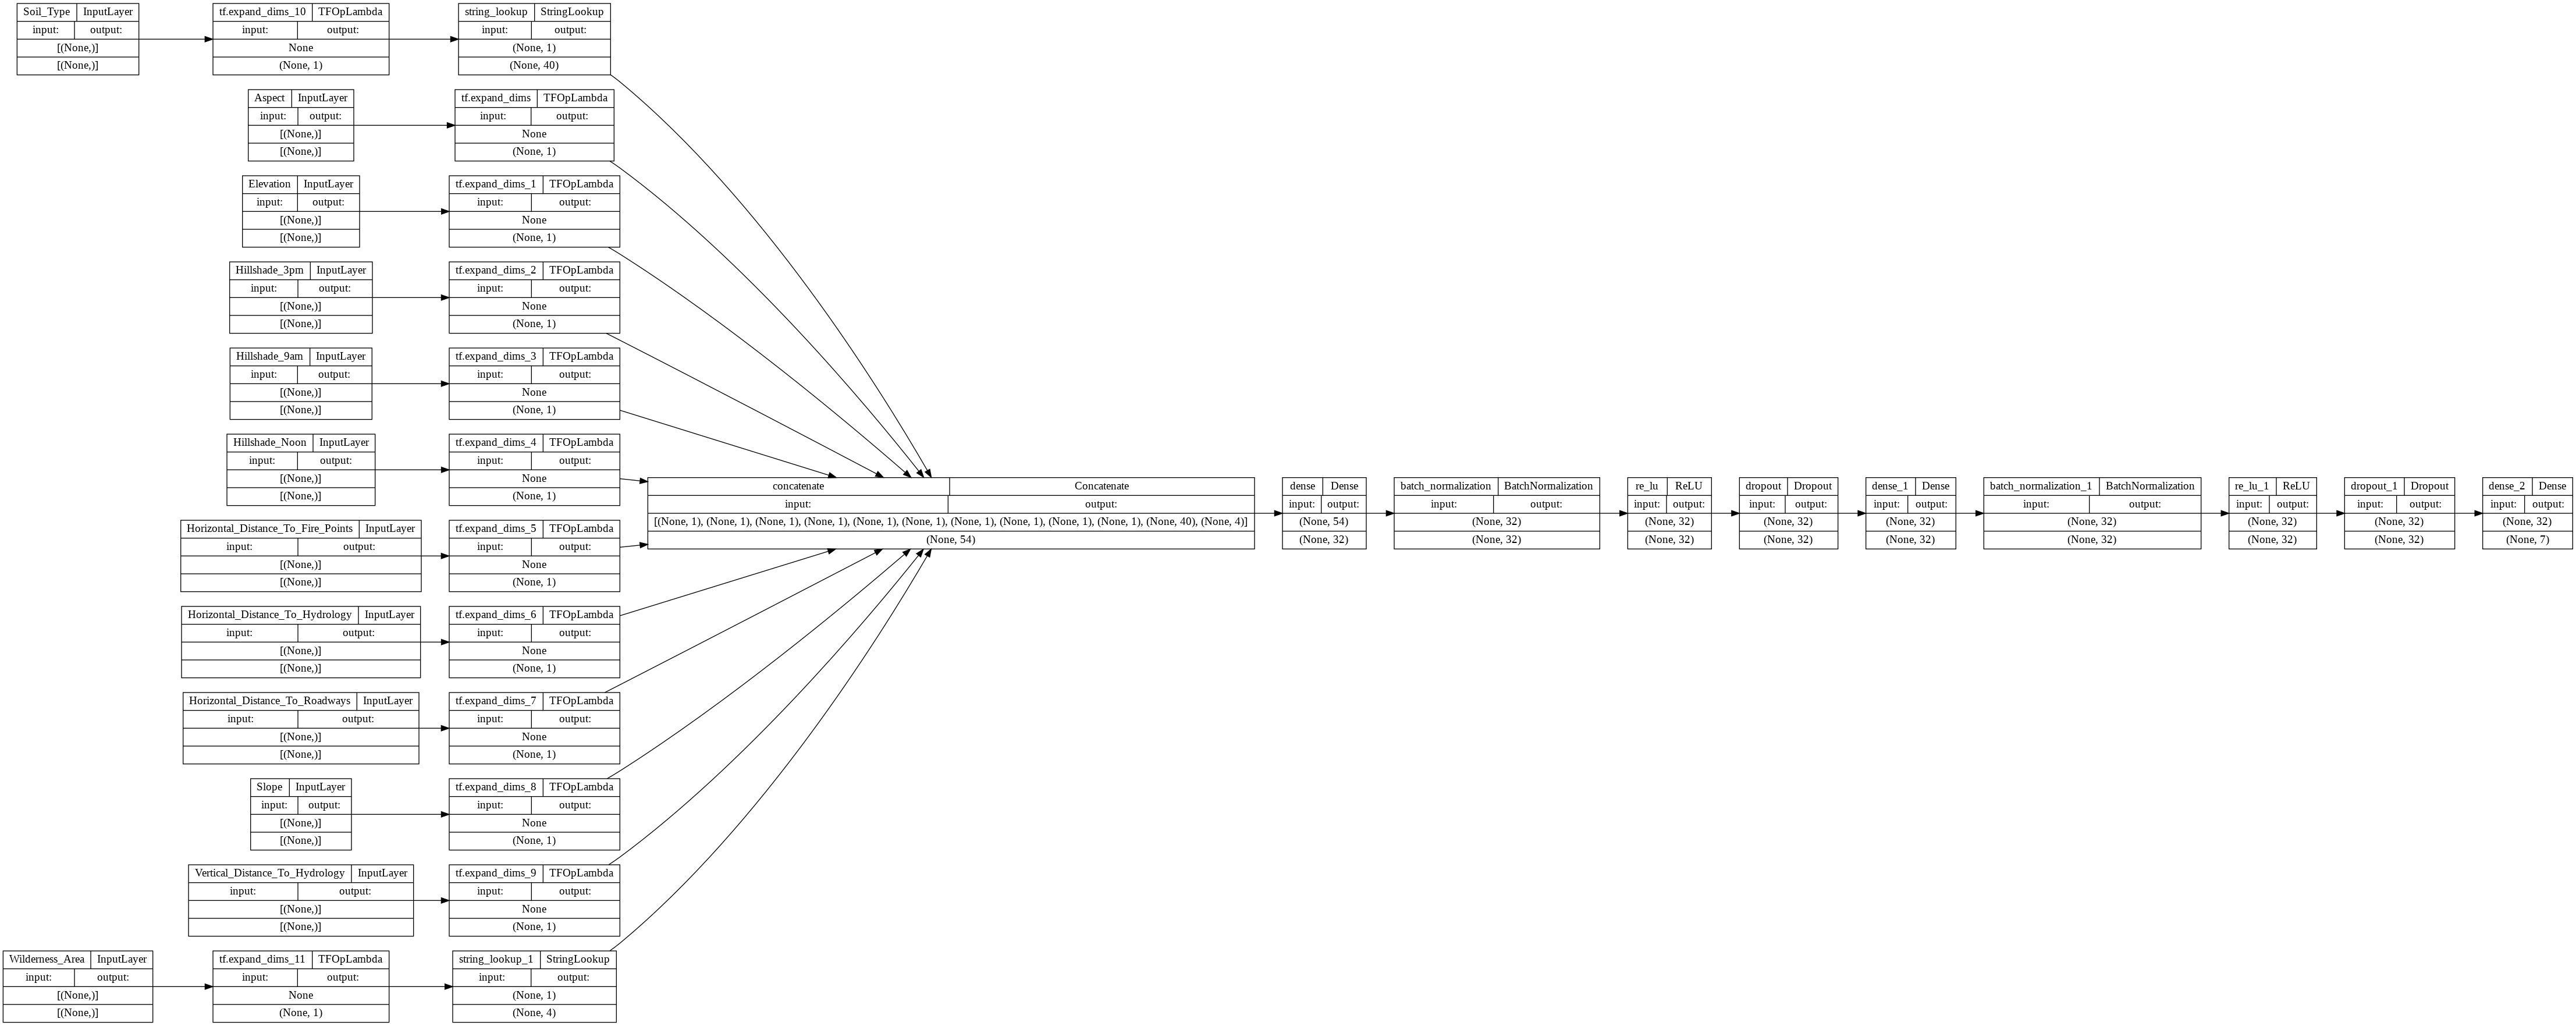

In [ ]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")
#Using One-hot Encoding

In [ ]:
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 18s 8ms/step - loss: 0.7956 - sparse_categorical_accuracy: 0.6751
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.7154
Epoch 3/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.7260
Epoch 4/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.7347
Epoch 5/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6048 - sparse_categorical_accuracy: 0.7405
Epoch 6/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5972 - sparse_categorical_accuracy: 0.7444
Epoch 7/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.7461
Epoch 8/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5864 - sparse_categorical_accuracy: 0.749

##Wide and Deep Model

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


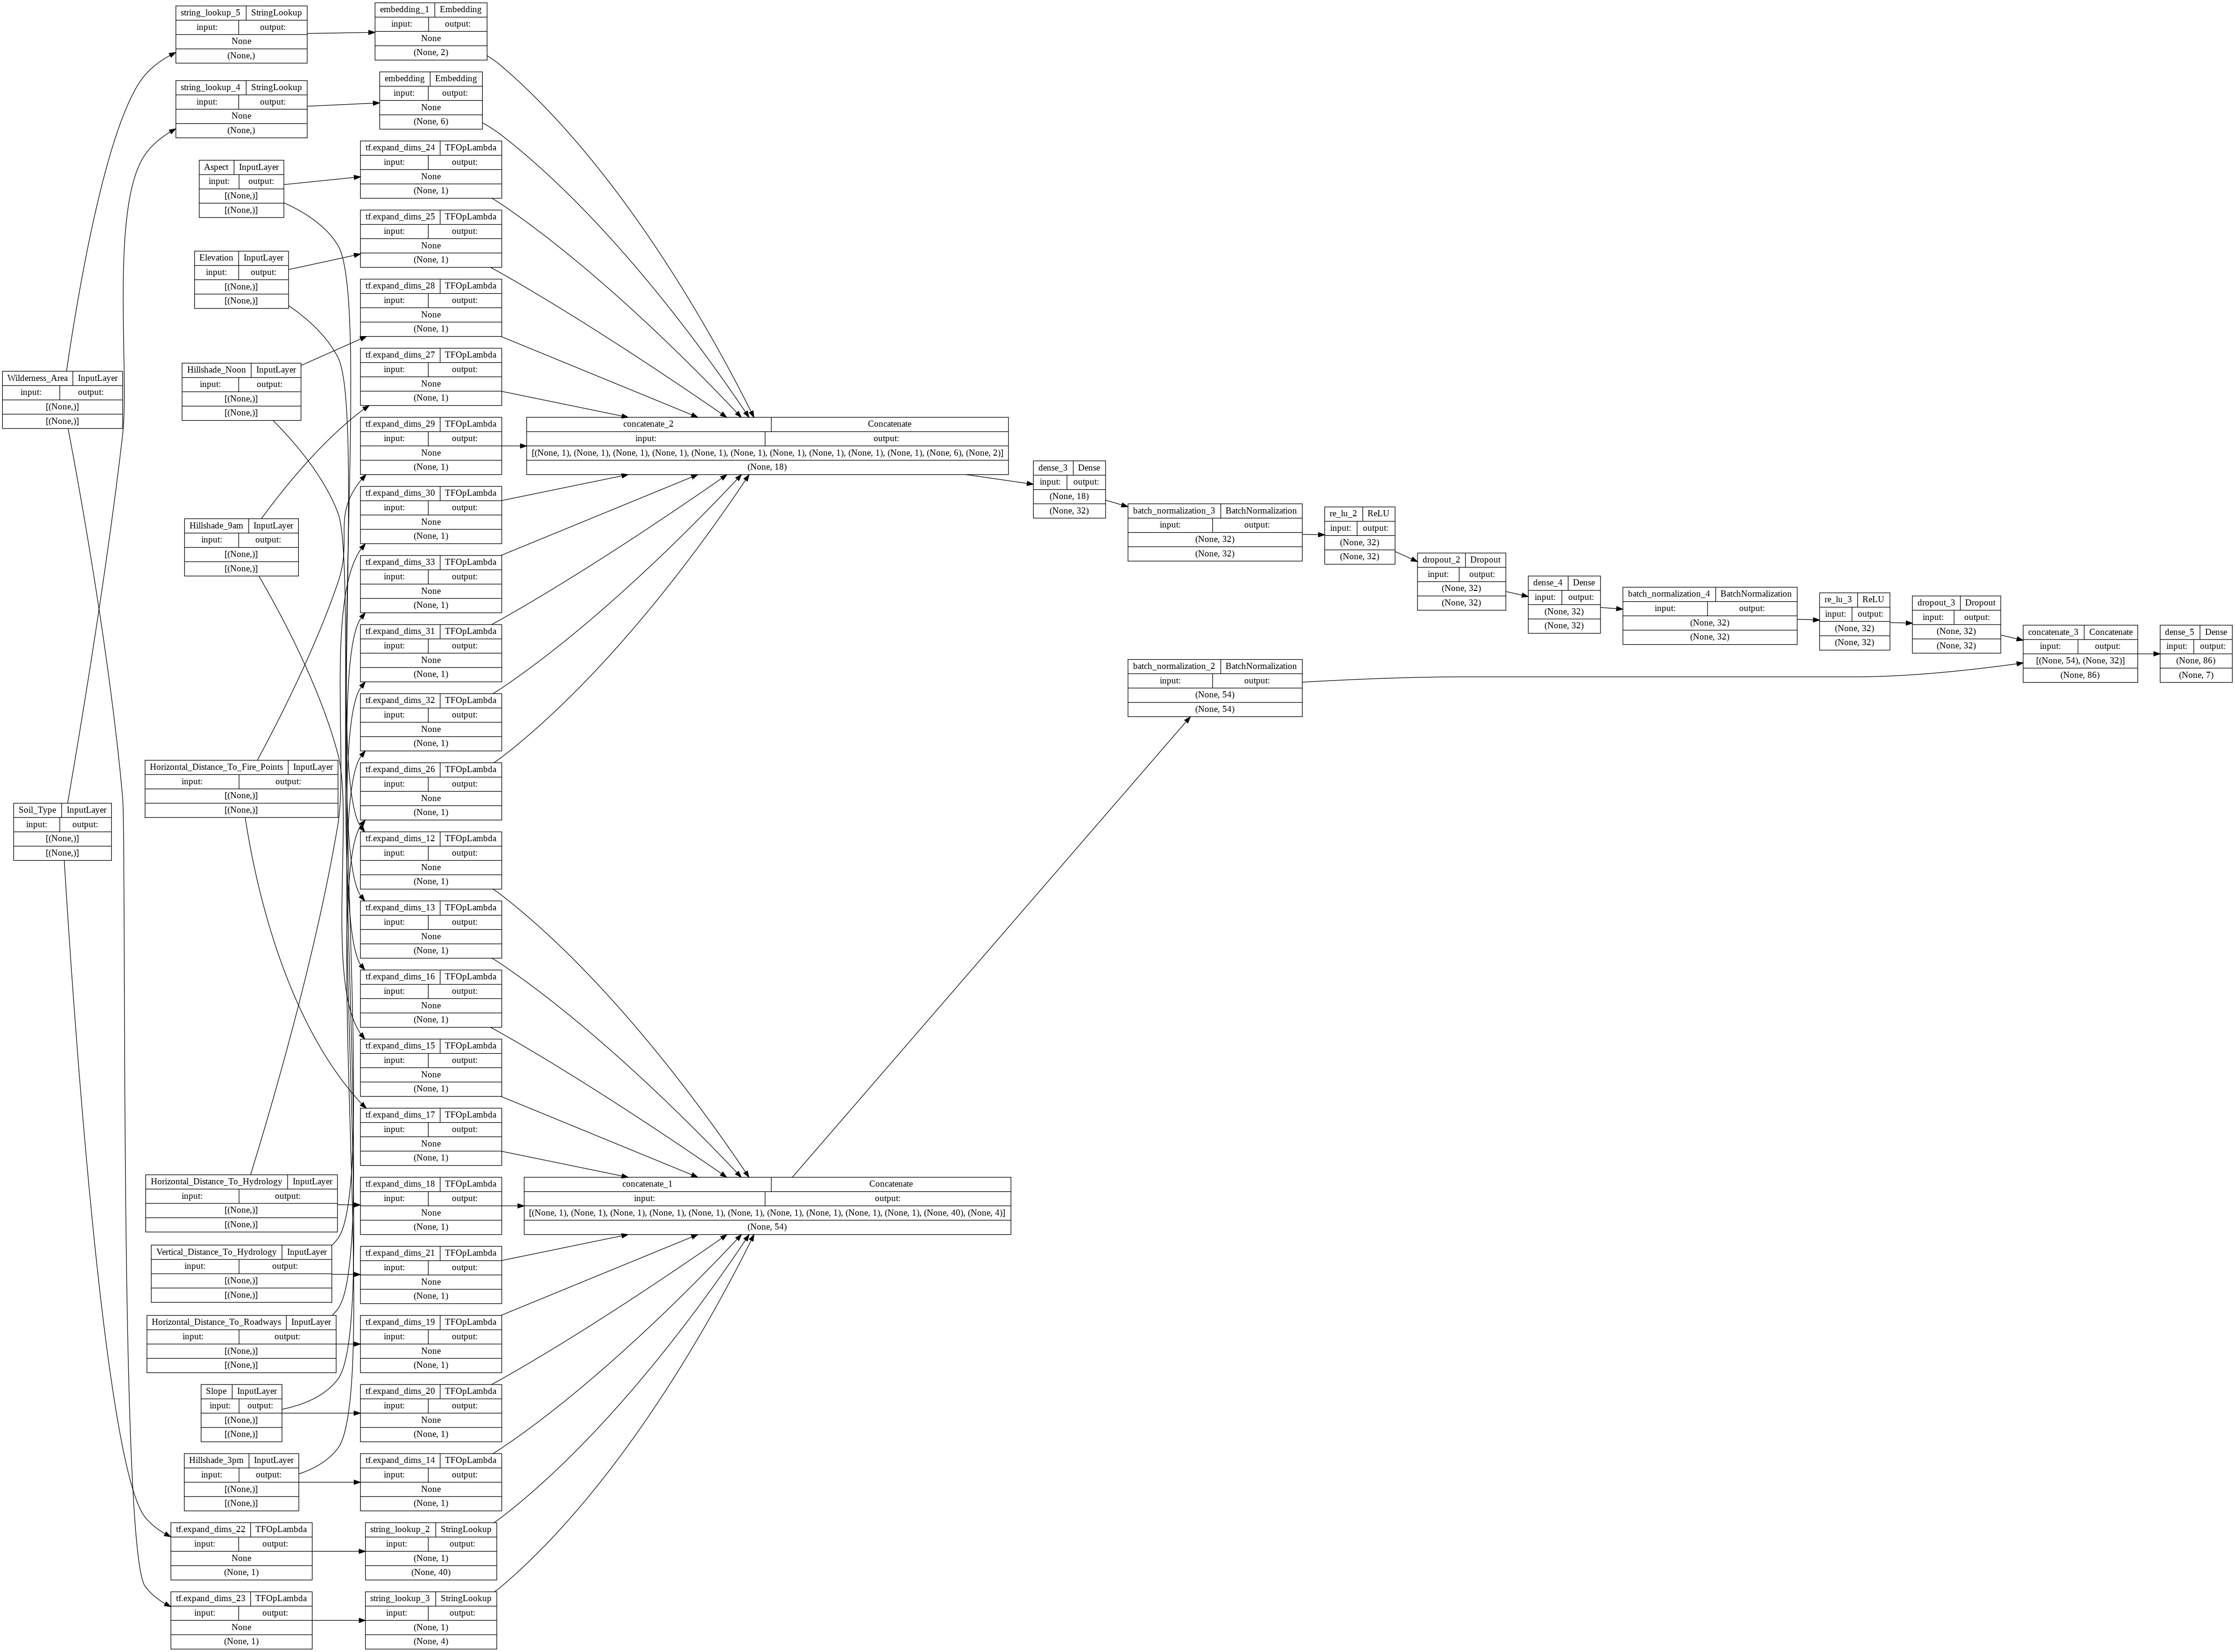

In [ ]:
#The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 18s 9ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.7056
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.7371
Epoch 3/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5879 - sparse_categorical_accuracy: 0.7448
Epoch 4/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.7513
Epoch 5/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5645 - sparse_categorical_accuracy: 0.7563
Epoch 6/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5579 - sparse_categorical_accuracy: 0.7593
Epoch 7/50
1864/1864 [==============================] - 12s 7ms/step - loss: 0.5515 - sparse_categorical_accuracy: 0.7622
Epoch 8/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5460 - sparse_categorical_accuracy: 0.7

##Deep and Cross Model

###With embedding


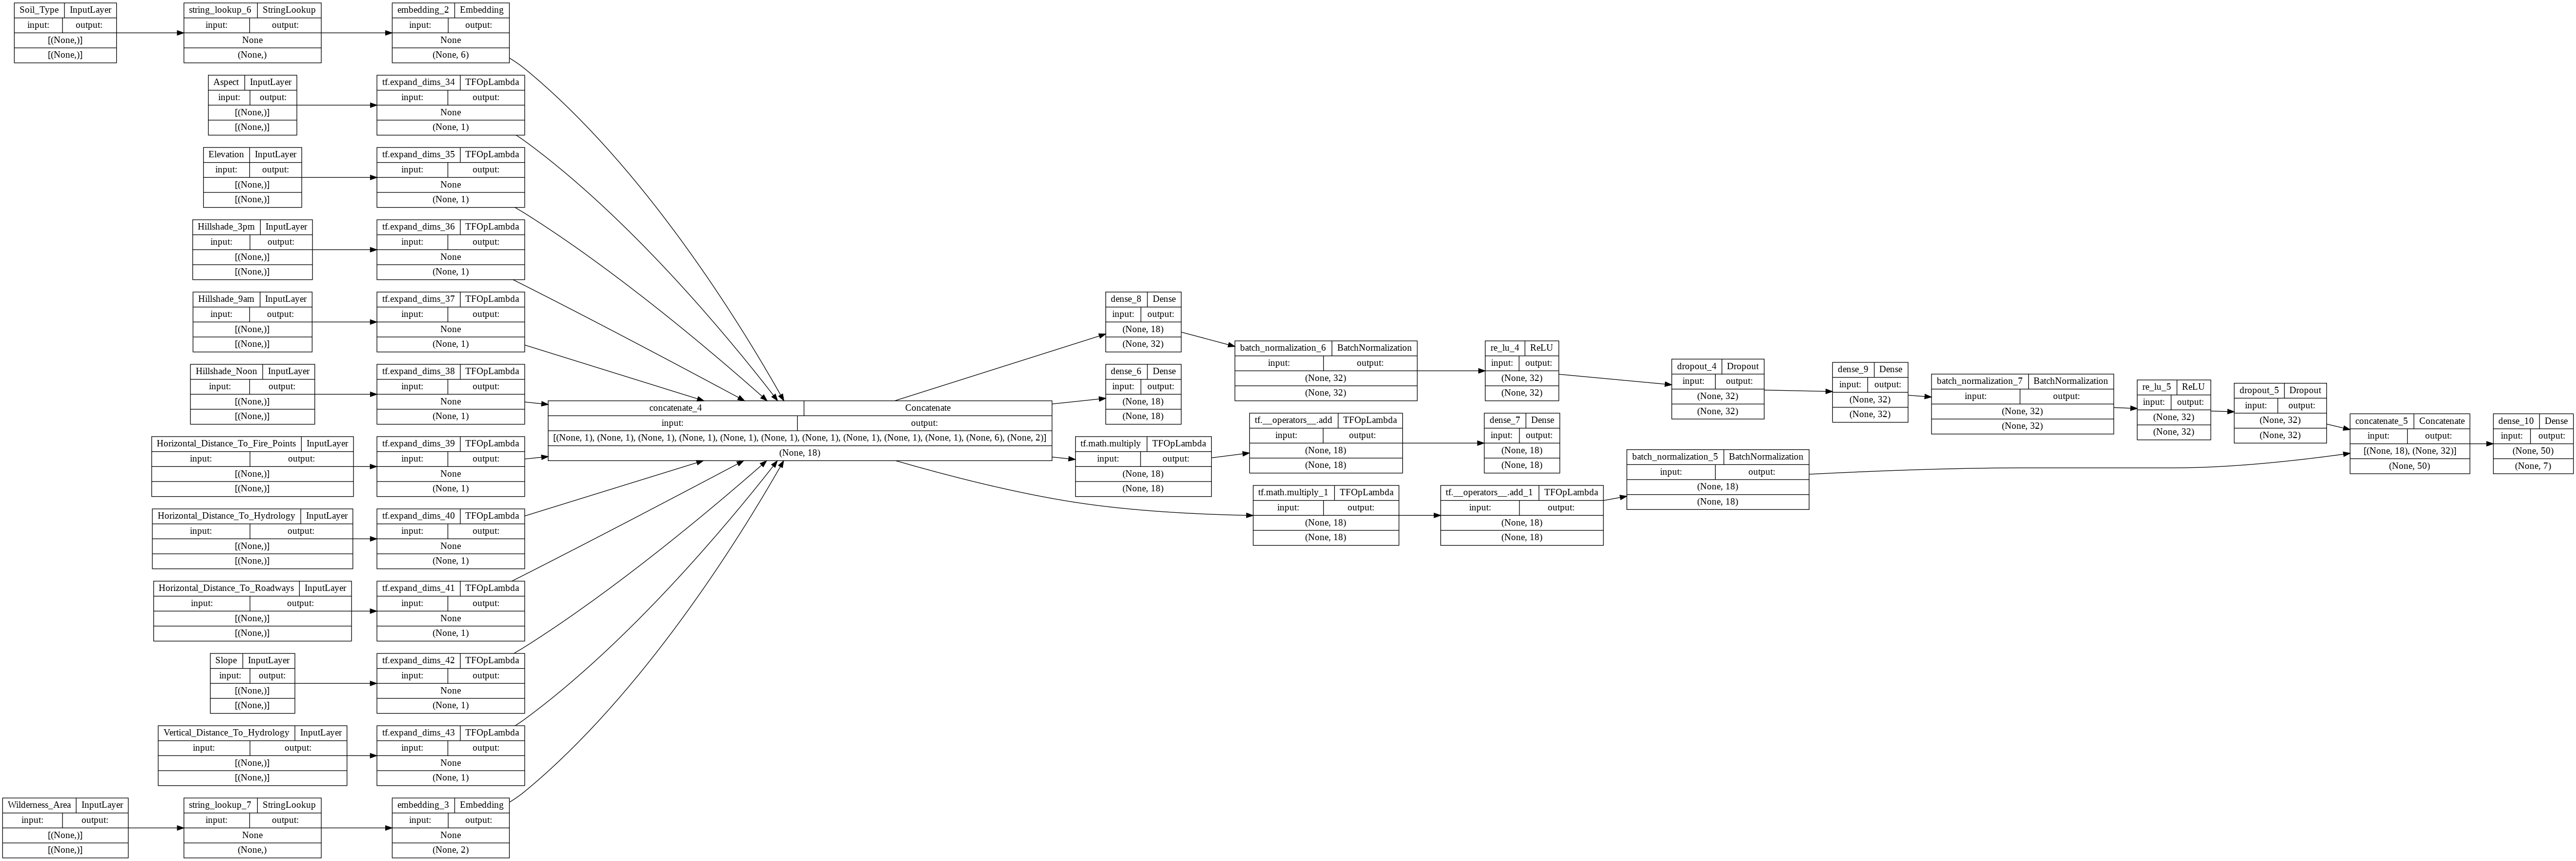

In [ ]:
#Deep model is a multi-layer feed forward network. The  key  idea  of  the  cross  part  isto  apply  explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 17s 9ms/step - loss: 0.6820 - sparse_categorical_accuracy: 0.7127
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5930 - sparse_categorical_accuracy: 0.7440
Epoch 3/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5738 - sparse_categorical_accuracy: 0.7509
Epoch 4/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5632 - sparse_categorical_accuracy: 0.7552
Epoch 5/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5546 - sparse_categorical_accuracy: 0.7581
Epoch 6/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5482 - sparse_categorical_accuracy: 0.7609
Epoch 7/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5431 - sparse_categorical_accuracy: 0.7634
Epoch 8/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5387 - sparse_categorical_accuracy: 0.7

###Without embedding

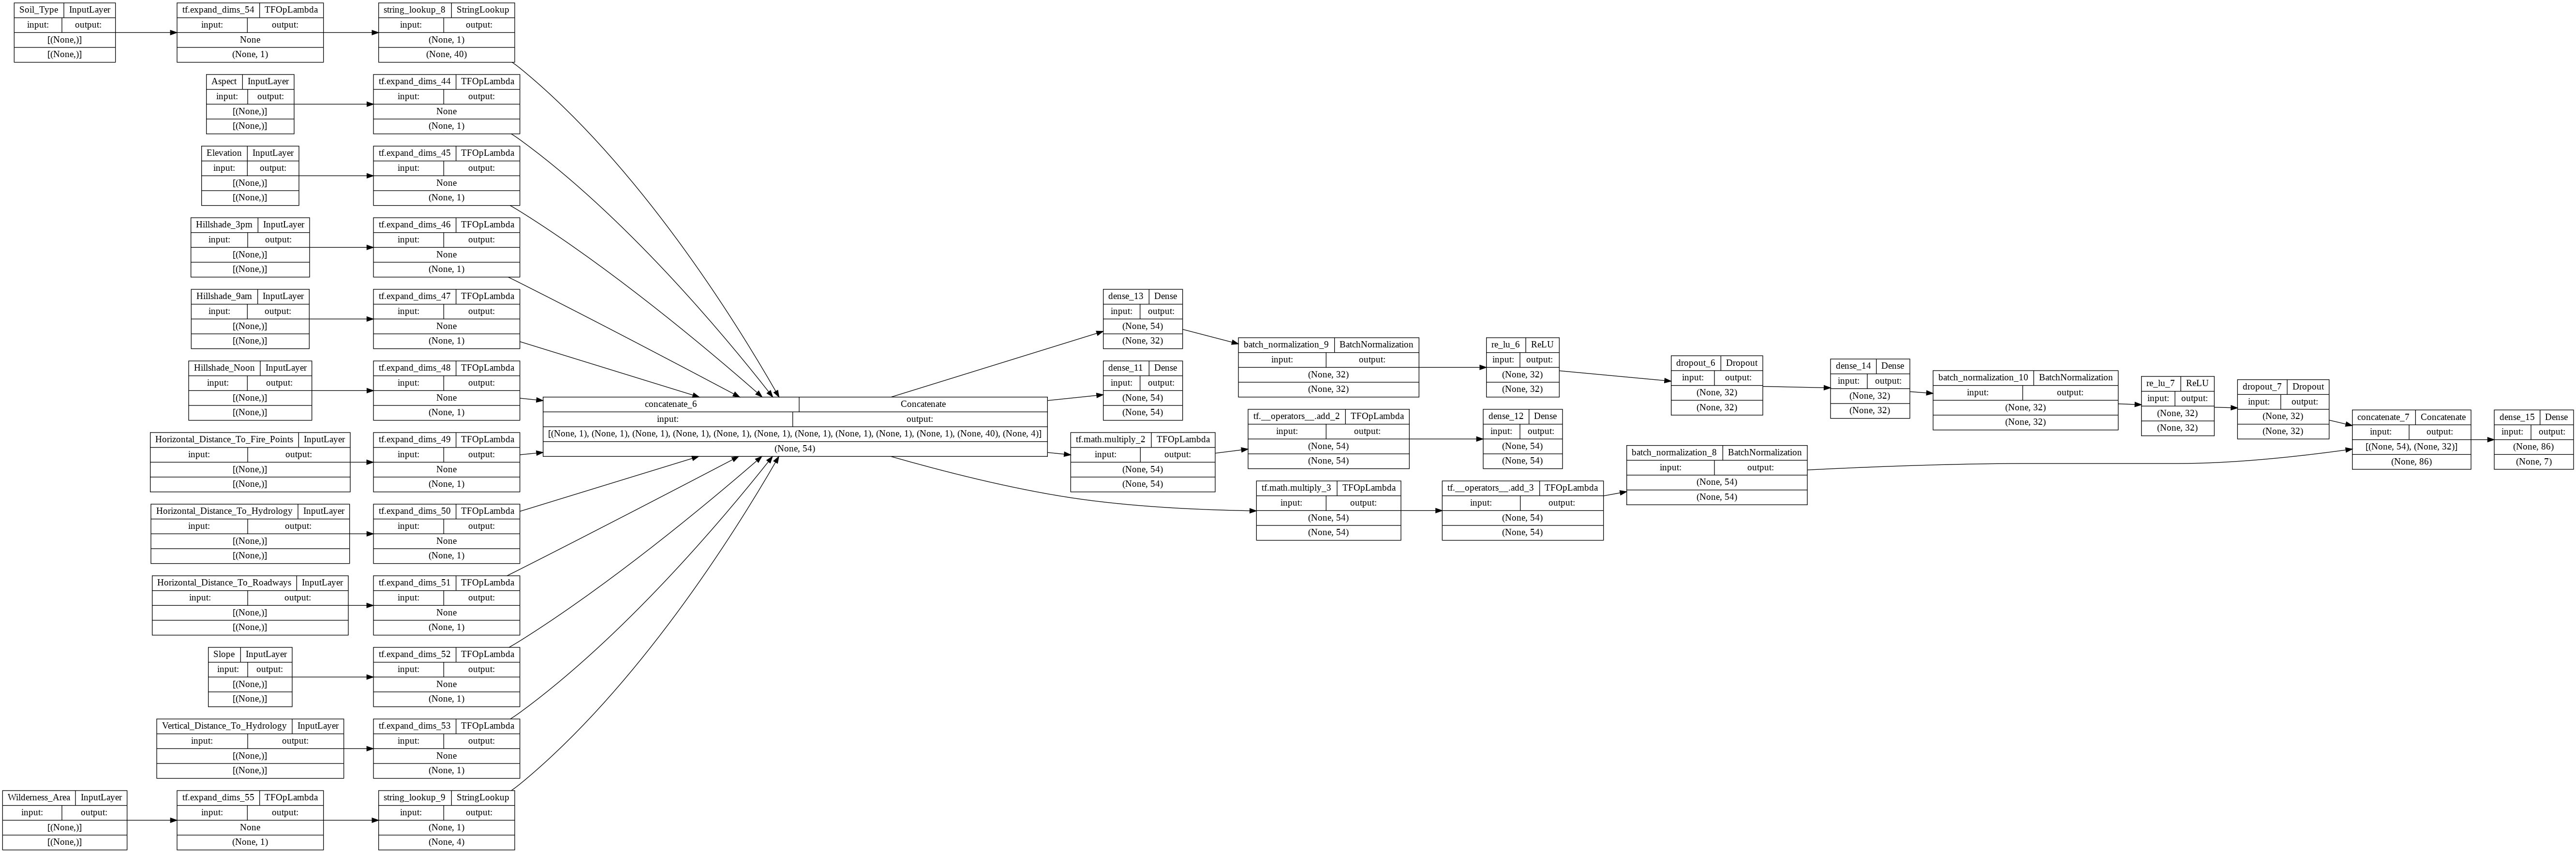

In [ ]:
#Deep model is a multi-layer feed forward network. The  key  idea  of  the  cross  part  isto  apply  explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=False)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 15s 8ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.7158
Epoch 2/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.7478
Epoch 3/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5626 - sparse_categorical_accuracy: 0.7562
Epoch 4/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.7617
Epoch 5/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5389 - sparse_categorical_accuracy: 0.7662
Epoch 6/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5324 - sparse_categorical_accuracy: 0.7696
Epoch 7/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5262 - sparse_categorical_accuracy: 0.7721
Epoch 8/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5220 - sparse_categorical_accuracy: 0.7

#EXERCISE - 2
Google Stock Price Prediction Dataset - RNN vs LSTM

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/archive/Google_Stock_Price_Train.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [ ]:
data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [ ]:
data.corr()

,Open,High,Low
Open,1.000000,0.999692,0.999498
High,0.999692,1.000000,0.999480
Low,0.999498,0.999480,1.000000


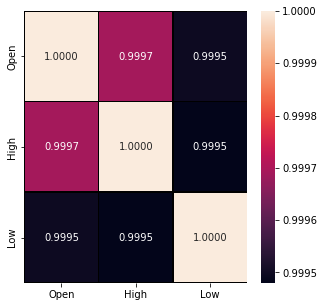

In [ ]:
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [ ]:
data_set = data.loc[:, ["Open"]].values
data_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [ ]:
train = data_set[:len(data_set) - 50]
test = data_set[len(train):]

train.reshape(train.shape[0],1)
train.shape

(1208, 1)

In [ ]:
# Normalization wiht MinmaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1)) # değerleri 0 ile 1 arasında sayılara indirger
train_scaler = scaler.fit_transform(train)
train_scaler

array([[0.08886192],
       [0.10045847],
       [0.09768454],
       ...,
       [0.96447835],
       [0.97998536],
       [1.        ]])

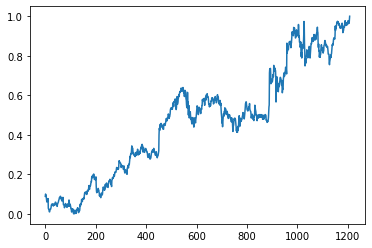

In [ ]:
plt.plot(train_scaler)
plt.show()

In [ ]:
#50 TIMESTEPS ARE USED FOR CREATING THE MODEL
X_train = []
Y_train = []
timesteps = 50

for i in range(timesteps, len(train_scaler)):
    X_train.append(train_scaler[i - timesteps:i, 0])
    Y_train.append(train_scaler[i,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)

# reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(1158, 50, 1)

[RNN VS LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


##RNN Model

In [ ]:
# Import Library 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

# Initialising the RNN
regressor = Sequential()

# Add the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

# Fitting the RNN to the training set
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 8s 164ms/step - loss: 0.4241
Epoch 2/100
37/37 [==============================] - 6s 163ms/step - loss: 0.2747
Epoch 3/100
37/37 [==============================] - 6s 161ms/step - loss: 0.2434
Epoch 4/100
37/37 [==============================] - 6s 161ms/step - loss: 0.1623
Epoch 5/100
37/37 [==============================] - 6s 161ms/step - loss: 0.1221
Epoch 6/100
37/37 [==============================] - 7s 182ms/step - loss: 0.1054
Epoch 7/100
37/37 [==============================] - 6s 161ms/step - loss: 0.0866
Epoch 8/100
37/37 [==============================] - 6s 160ms/step - loss: 0.0797
Epoch 9/100
37/37 [==============================] - 8s 207ms/step - loss: 0.0643
Epoch 10/100
37/37 [==============================] - 6s 161ms/step - loss: 0.0647
Epoch 11/100
37/37 [==============================] - 6s 165ms/step - loss: 0.0523
Epoch 12/100
37/37 [==============================] - 6s 163ms/step - loss: 0.0436
Epoch 13/100


####Why using tanh instead of ReLU in activation function in RNN and LSTM'S
The main problem in RNN is the vanishing gradient problem. Also, to keep the gradient in the linear region of the activation function, we need a function whose second derivative can sustain for a long range before going to zero.

Tanh is a good function with the above properties.
LSTMs manage an internal state vector whose values should be able to increase or decrease when we add the output of some function. Sigmoid output is always non-negative; values in the state would only increase. The output from tanh can be positive or negative, allowing for increases and decreases in the state.

That's why tanh is used to determine candidate values to get added to the internal state. The GRU cousin of the LSTM doesn't have a second tanh, so in a sense the second one is not necessary.

In [ ]:
inputs = data_set[len(data_set) - len(test) - timesteps:]
inputs = scaler.transform(inputs)


In [ ]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i - timesteps:i, 0])
    
X_test_rnn = np.array(X_test)
X_test_rnn = np.reshape(X_test_rnn, (X_test_rnn.shape[0], X_test_rnn.shape[1], 1))
predicted_stock_price = regressor.predict(X_test_rnn)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

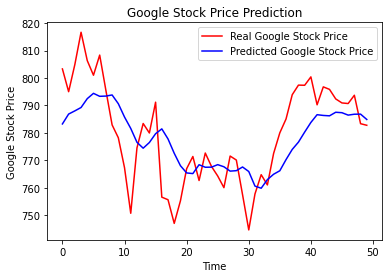

In [ ]:
# visualising the results
plt.plot(test, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()

##LSTM Model

In [ ]:
# Import Library For LSTM Model
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
train_X = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [ ]:
train_X.shape

(1158, 1, 50)

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape = (1, timesteps)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.fit(train_X, Y_train, epochs = 50, batch_size = 1)


Epoch 1/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0036
Epoch 2/50
1158/1158 [==============================] - 3s 3ms/step - loss: 0.0015
Epoch 3/50
1158/1158 [==============================] - 3s 3ms/step - loss: 0.0011
Epoch 4/50
1158/1158 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 5/50
1158/1158 [==============================] - 6s 5ms/step - loss: 0.0010
Epoch 6/50
1158/1158 [==============================] - 3s 3ms/step - loss: 9.5093e-04
Epoch 7/50
1158/1158 [==============================] - 3s 3ms/step - loss: 7.8448e-04
Epoch 8/50
1158/1158 [==============================] - 3s 3ms/step - loss: 7.4048e-04
Epoch 9/50
1158/1158 [==============================] - 3s 3ms/step - loss: 7.0942e-04
Epoch 10/50
1158/1158 [==============================] - 3s 3ms/step - loss: 7.2210e-04
Epoch 11/50
1158/1158 [==============================] - 3s 3ms/step - loss: 7.1842e-04
Epoch 12/50
1158/1158 [==============================] - 3s 3

In [ ]:
# Prepare test dataset
test_X = np.array(X_test)
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

# Predict with test_X
predict_lstm = model.predict(test_X)
predict_lstm = scaler.inverse_transform(predict_lstm)

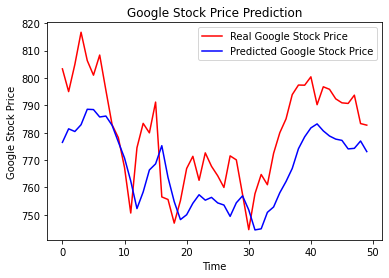

In [ ]:
# visualising the results
plt.plot(test, color = "red", label = "Real Google Stock Price")
plt.plot(predict_lstm, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()